In [3]:
import os,sys
import numpy as np
import h5py
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
# from tqdm import tqdm
# from PIL import Image

/Users/aizhan/.virtualenvs/conv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
data_root='.'
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
print(train.label.nunique(),'labels')
label_counts=train.label.value_counts()
print(label_counts)

25 labels
candy          242
chocolate      199
juice          196
coffee         194
tea            184
cereal         181
water          170
jam            157
spices         135
honey          120
chips          118
soda           115
pasta          112
tomatosauce    111
nuts           109
milk           105
cake           105
vinegar        102
rice            97
oil             93
beans           88
sugar           77
flour           71
fish            71
corn            63
Name: label, dtype: int64


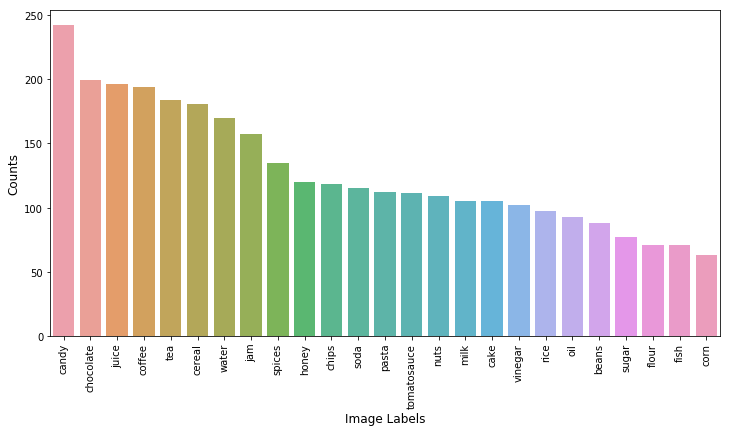

In [5]:

plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()


In [6]:
for img in tqdm(train.values):
    filename=img[0]
    label=img[1]
    src=os.path.join(data_root,'train_img',filename+'.png')
    label_dir=os.path.join(data_root,'train',label)
    dest=os.path.join(label_dir,filename+'.jpg')
    im=Image.open(src)
    rgb_im=im.convert('RGB')
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    rgb_im.save(dest)  
    if not os.path.exists(os.path.join(data_root,'train2',label)):
        os.makedirs(os.path.join(data_root,'train2',label))
    rgb_im.save(os.path.join(data_root,'train2',label,filename+'.jpg'))

100%|██████████| 3215/3215 [00:54<00:00, 59.04it/s]


In [7]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

class_size=600

src_train_dir=os.path.join(data_root,'train')
dest_train_dir=os.path.join(data_root,'train2')
it=0
for count in label_counts.values:
    #nb of generations per image for this class label in order to make it size ~= class_size
    ratio=math.floor(class_size/count)-1
    print(count,count*(ratio+1))
    dest_lab_dir=os.path.join(dest_train_dir,label_counts.index[it])
    src_lab_dir=os.path.join(src_train_dir,label_counts.index[it])
    if not os.path.exists(dest_lab_dir):
        os.makedirs(dest_lab_dir)
    for file in os.listdir(src_lab_dir):
        img=load_img(os.path.join(src_lab_dir,file))
        #img.save(os.path.join(dest_lab_dir,file))
        x=img_to_array(img) 
        x=x.reshape((1,) + x.shape)
        i=0
        for batch in datagen.flow(x, batch_size=1,save_to_dir=dest_lab_dir, save_format='jpg'):
            i+=1
            if i > ratio:
                break 
    it=it+1

242 484
199 597
196 588
194 582
184 552
181 543
170 510
157 471
135 540
120 600
118 590
115 575
112 560
111 555
109 545
105 525
105 525
102 510
97 582
93 558
88 528
77 539
71 568
71 568
63 567


In [8]:
for dirpath, dirnames, filenames in os.walk(dest_train_dir):
    i=0
    label=''
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        label=os.path.split(dirpath)[1]
        i+=1
    print(label,i)

 0
beans 1092
cake 1099
candy 1591
cereal 1688
chips 1223
chocolate 1836
coffee 1806
corn 1126
fish 1150
flour 1146
honey 1404
jam 1485
juice 1790
milk 1095
nuts 1125
oil 1169
pasta 1173
rice 1191
soda 1206
spices 1610
sugar 1099
tea 1717
tomatosauce 1144
vinegar 1083
water 1586


In [9]:
for dirpath, dirnames, filenames in os.walk(src_train_dir):
    i=0
    label=''
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        label=os.path.split(dirpath)[1]
        i+=1
    print(label,i)

 0
beans 88
cake 105
candy 242
cereal 181
chips 118
chocolate 199
coffee 194
corn 63
fish 71
flour 71
honey 120
jam 157
juice 196
milk 105
nuts 109
oil 93
pasta 112
rice 97
soda 115
spices 135
sugar 77
tea 184
tomatosauce 111
vinegar 102
water 170


In [16]:
import cv2

In [17]:
# set path to read train and test image
TRAIN_PATH = 'train_img/'
TEST_PATH = 'test_img/'

In [18]:
# function to read images as arrays
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64)) # you can resize to  (128,128) or (256,256)
    return img

In [19]:
train_data = []
test_data = []
train_labels = train['label'].values

for img in tqdm(train['image_id'].values):
    train_data.append(read_image(TRAIN_PATH + '{}.png'.format(img)))
    
for img in tqdm(test['image_id'].values):
    test_data.append(read_image(TEST_PATH + '{}.png'.format(img)))

100%|██████████| 1732/1732 [00:06<00:00, 269.31it/s]


In [20]:
# normalize the images
x_train = np.array(train_data, np.float32) / 255.
x_test = np.array(test_data, np.float32) / 255.

In [21]:
# target variable - encoding numeric value
label_list = train['label'].tolist()
Y_train = {k:v+1 for v,k in enumerate(set(label_list))}
y_train = [Y_train[k] for k in label_list]

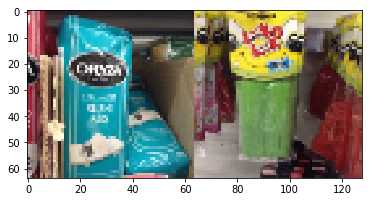

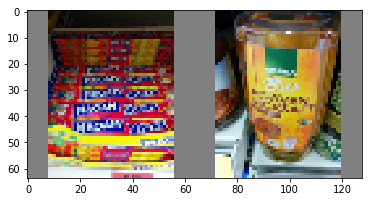

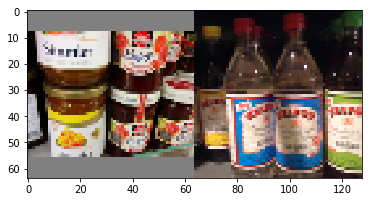

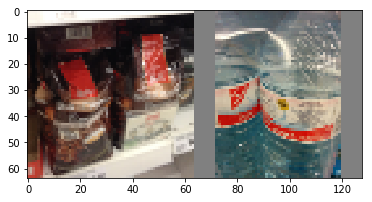

In [22]:
# check some images
def show_images(ix):
    image_train = read_image(TRAIN_PATH + train.image_id[ix] + '.png')
    image_test = read_image(TEST_PATH + test.image_id[ix] + '.png')
    
    pair = np.concatenate((image_train, image_test), axis=1)
    
    plt.figure(figsize = (6,6))
    plt.imshow(pair)
    
# first 4 images in train and test set
for idx in range(4):
    show_images(idx)

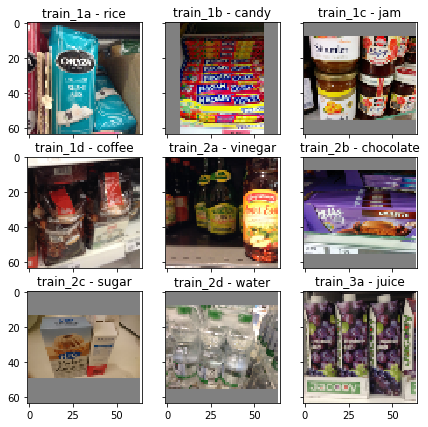

In [23]:
## just images doesn't help, lets see the images with their respective labels
plt.rc('axes', grid=False)

_, axs = plt.subplots(3,3, sharex = 'col', sharey='row', figsize = (7,7))
axs = axs.ravel()

# lets see first 8 images - you can increase i value to see more images
for i, (image_name, label) in enumerate(zip(train.image_id, train.label)):
    if i <= 8:
        img = read_image(TRAIN_PATH + image_name + '.png')
        axs[i].imshow(img)
        axs[i].set_title('{} - {}'.format(image_name, label))
    else:
        break

In [24]:

# lets train our first model, we'll use keras.

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [25]:
## keras accepts target variable as a ndarray so that we can set one output neuron per class
y_train = to_categorical(y_train)

In [39]:
## neural net architechture

model = Sequential()
model.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (64,64,3))) # if you resize the image above, shape would be (128,128,3)
model.add(Convolution2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
# model.add(Convolution2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [40]:
early_stops = EarlyStopping(patience=3, monitor='val_acc')

In [42]:
model.fit(x_train, y_train, batch_size=10, epochs=6, validation_split=0.3, callbacks=[early_stops])

Train on 2250 samples, validate on 965 samples
Epoch 1/6
2250/2250 [==============================] - 75s 33ms/step - loss: 3.1849 - acc: 0.0649 - val_loss: 3.1434 - val_acc: 0.0756
Epoch 2/6
2250/2250 [==============================] - 68s 30ms/step - loss: 3.0744 - acc: 0.1044 - val_loss: 2.9525 - val_acc: 0.1171
Epoch 3/6
2250/2250 [==============================] - 68s 30ms/step - loss: 2.8958 - acc: 0.1551 - val_loss: 2.8283 - val_acc: 0.1772
Epoch 4/6
2250/2250 [==============================] - 68s 30ms/step - loss: 2.7768 - acc: 0.1822 - val_loss: 2.7843 - val_acc: 0.1585
Epoch 5/6
2250/2250 [==============================] - 71s 31ms/step - loss: 2.6217 - acc: 0.2222 - val_loss: 2.6754 - val_acc: 0.2187
Epoch 6/6
2250/2250 [==============================] - 68s 30ms/step - loss: 2.4553 - acc: 0.2622 - val_loss: 2.6270 - val_acc: 0.2249


In [43]:
# make prediction
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis= 1)


In [44]:
predictions

array([21, 16, 12, ..., 16, 12,  3])

In [45]:
# get predicted labels
y_maps = dict()
y_maps = {v:k for k, v in Y_train.items()}
pred_labels = [y_maps[k] for k in predictions]

In [46]:
# make submission
sub1 = pd.DataFrame({'image_id':test.image_id, 'label':pred_labels})
sub1.to_csv('sub.csv', index=False)

Category: juice


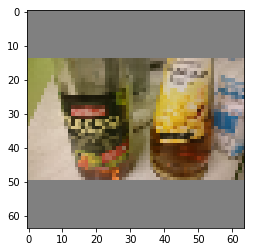

Category: chocolate


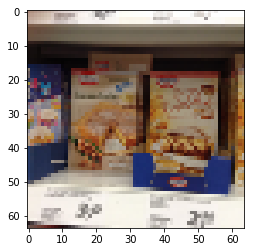

Category: pasta


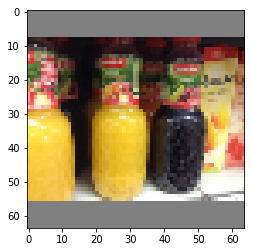

Category: candy


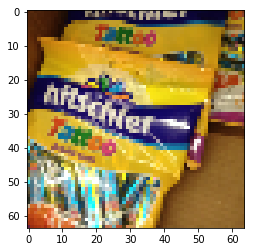

Category: jam


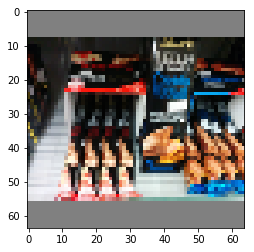

In [54]:
## lets see what our classifier predicts on test images

# top 5 predictions
for i in range(20, 25):
    print('Category: {}'.format(pred_labels[i]))
    plt.imshow(read_image(TEST_PATH +'{}.png'.format(test.image_id[i])))
    plt.show()

In [65]:
test=pd.read_csv('test.csv')
print(test.label.nunique(),'labels')
label_counts=test.label.value_counts()
print(label_counts)

AttributeError: 'DataFrame' object has no attribute 'label'